<a href="https://colab.research.google.com/github/marcusnk237/ecg-classification-ml/blob/main/ecg_classification_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Téléchargement du Dataset depuis Kaggle

###Chargement du kaggle.json

In [10]:
### Installer Kaggle ###
! pip install -q kaggle
########################

### Selectionner le fichier kaggle.json ##
from google.colab import files
files.upload()
##########################################

Saving kaggle.json to kaggle (1).json


{'kaggle.json': b'{"username":"marcjuniornkengue","key":"57136abdc8186b604e103212b3ffe79a"}'}

### Copie du fichier .json et modification des autorisations

In [11]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json

kaggle.json


### Téléchargement du Dataset

In [12]:
!kaggle datasets download -d marcjuniornkengue/hearbeat

 93% 92.0M/98.8M [00:00<00:00, 114MB/s] 
100% 98.8M/98.8M [00:00<00:00, 183MB/s]


### Décompression du fichier téléchargé

In [13]:
!unzip \*.zip  && rm *.zip

Archive:  hearbeat.zip
replace mitbih_test.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: mitbih_test.csv         
  inflating: mitbih_train.csv        
  inflating: ptbdb_abnormal.csv      
  inflating: ptbdb_normal.csv        


# Importation des bibliothèques

In [14]:
import numpy as np 
import pandas as pd 
import keras
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import os
import itertools

from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.utils import class_weight
from sklearn.utils import resample


from keras.utils.np_utils import to_categorical
from keras.layers import Dense, Convolution1D, MaxPool1D, Flatten, Dropout
from keras.layers import Input
from keras.models import Model
from keras.layers.normalization import BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint

# Fonctions de base

### Histogramme de classes

In [15]:
def plot_hist(class_number,size,min_):
    # Classe de données
    img=train_df.loc[train_df[187]==class_number].values
    # Rognage
    img=img[:,min_:size]
    # Mise à plat des données
    img_flatten=img.flatten()
    
    final1=np.arange(min_,size)
    for i in range (img.shape[0]-1):
        tempo1=np.arange(min_,size)
        final1=np.concatenate((final1, tempo1), axis=None)
    print(len(final1))
    print(len(img_flatten))
    plt.hist2d(final1,img_flatten, bins=(80,80),cmap=plt.cm.jet)
    plt.show()

### Bruit Gaussien

In [16]:
def add_gaussian_noise(signal,avg=0,std=0.05,n=186):
    noise=np.random.normal(avg,std,n)
    return (signal+noise)

### Définition du modèle

In [17]:
def network(X_train,y_train,X_test,y_test):
    
    #################################### Définition du modèle  ####################################
    im_shape=(X_train.shape[1],1)
    inputs_cnn=Input(shape=(im_shape), name='inputs_cnn')
    conv1_1=Convolution1D(64, (6), activation='relu', input_shape=im_shape)(inputs_cnn)
    conv1_1=BatchNormalization()(conv1_1)
    pool1=MaxPool1D(pool_size=(3), strides=(2), padding="same")(conv1_1)
    conv2_1=Convolution1D(64, (3), activation='relu', input_shape=im_shape)(pool1)
    conv2_1=BatchNormalization()(conv2_1)
    pool2=MaxPool1D(pool_size=(2), strides=(2), padding="same")(conv2_1)
    conv3_1=Convolution1D(64, (3), activation='relu', input_shape=im_shape)(pool2)
    conv3_1=BatchNormalization()(conv3_1)
    pool3=MaxPool1D(pool_size=(2), strides=(2), padding="same")(conv3_1)
    flatten=Flatten()(pool3)
    dense_end1 = Dense(64, activation='relu')(flatten)
    dense_end2 = Dense(32, activation='relu')(dense_end1)
    main_output = Dense(5, activation='softmax', name='main_output')(dense_end2)
    model = Model(inputs= inputs_cnn, outputs=main_output)
    ###############################################################################################
    
    ####################################### Compilation #######################################
    model.compile(optimizer='adam', loss='categorical_crossentropy',metrics = ['accuracy'])
    ###########################################################################################
    
    ############################################## Entrainement du modèle ##############################################
    callbacks = [EarlyStopping(monitor='val_loss', patience=8),
             ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]

    history=model.fit(X_train, y_train,epochs=20,callbacks=callbacks, batch_size=32,validation_data=(X_test,y_test))
    ####################################################################################################################
    model.load_weights('best_model.h5')
    return(model,history)

### Evaluation du modèle

In [18]:
def evaluate_model(history,X_test,y_test,model):
    ################ Evaluation du modèle ####################
    scores = model.evaluate((X_test),y_test, verbose=0)
    print("Précision: %.2f%%" % (scores[1]*100))
    ##########################################################
    
    print(history)
    fig1, ax_acc = plt.subplots()
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.xlabel('Epoch')
    plt.ylabel('Précision')
    plt.title('Précision du Modèle')
    plt.legend(['Entrainement', 'Validation'], loc='lower right')
    plt.show()
    
    fig2, ax_loss = plt.subplots()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Pertes du Modèle')
    plt.legend(['Entrainement', 'Validation'], loc='upper right')
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.show()
    target_names=['0','1','2','3','4']
    
    y_true=[]
    for element in y_test:
        y_true.append(np.argmax(element))
    prediction_proba=model.predict(X_test)
    prediction=np.argmax(prediction_proba,axis=1)
    cnf_matrix = confusion_matrix(y_true, prediction)

### Matrice de confusion

In [19]:
def plot_confusion_matrix(cm, classes,normalize=False,title='Matrice de Confusion',cmap=plt.cm.Blues):
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Matrice de Confusion Normalisée")
    else:
        print('Matrice de Confusion')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Classe')
    plt.xlabel('Classe Prédite')

# Programme Principal

### Chargement du dataset

In [20]:
# Les fichiers ont été téléchargés à la racine du programme
train_df = pd.read_csv("/content/mitbih_train.csv", header = None) 
test_df = pd.read_csv("/content/mitbih_test.csv", header = None)

### Re-équilibrage et re-échantillonnage des données

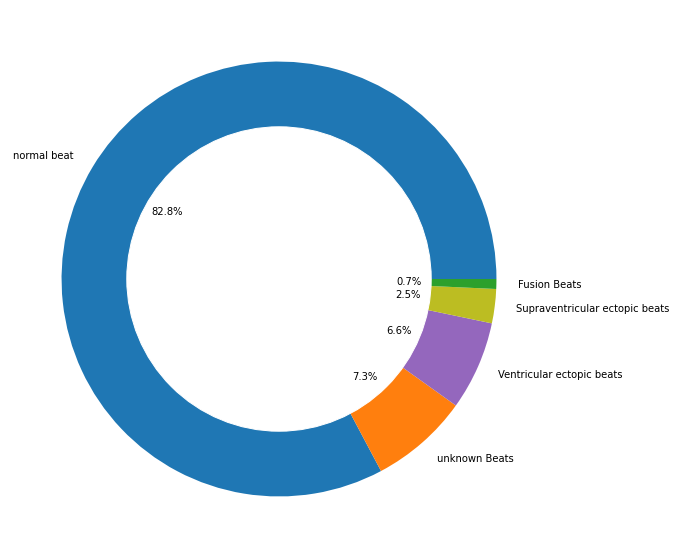

In [21]:
####################  Récupération des données par classe ####################
train_df[187].value_counts()
per_class = train_df[187].value_counts()
###############################################################################

################################################################################ Représentation des classes de données par pourcentage ####################################################################################################
plt.figure(figsize=(20,10))
my_circle=plt.Circle( (0,0), 0.7, color='white')
plt.pie(per_class, labels=['normal beat','unknown Beats','Ventricular ectopic beats','Supraventricular ectopic beats','Fusion Beats'], colors=['tab:blue','tab:orange','tab:purple','tab:olive','tab:green'],autopct='%1.1f%%')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.show()
############################################################################################################################################################################################################################################

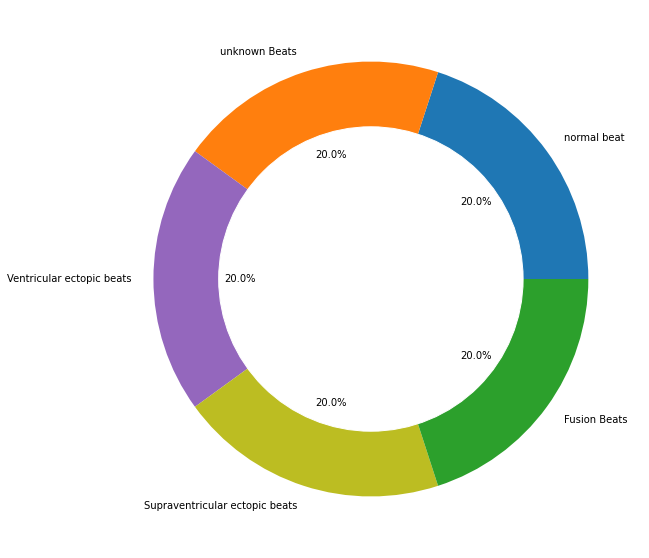

In [22]:
###################################### Récupération des données par classe ##################################
df_1=train_df[train_df[187]==1]
df_2=train_df[train_df[187]==2]
df_3=train_df[train_df[187]==3]
df_4=train_df[train_df[187]==4]
df_0=(train_df[train_df[187]==0]).sample(n=20000,random_state=42)
#############################################################################################################

########################## Re-échantillonnage des données ##########################
df_1_upsample=resample(df_1,replace=True,n_samples=20000,random_state=123)
df_2_upsample=resample(df_2,replace=True,n_samples=20000,random_state=124)
df_3_upsample=resample(df_3,replace=True,n_samples=20000,random_state=125)
df_4_upsample=resample(df_4,replace=True,n_samples=20000,random_state=126)
####################################################################################

############################## Reconstitution des données ##############################
train_df=pd.concat([df_0,df_1_upsample,df_2_upsample,df_3_upsample,df_4_upsample])
########################################################################################

# Nombre de données par classe #
train_df[187].value_counts()
################################
############################################################################################################ Pourcentage de repartition des classes ############################################################################################################
per_class = train_df[187].value_counts()
plt.figure(figsize=(20,10))
my_circle=plt.Circle( (0,0), 0.7, color='white')
plt.pie(per_class, labels=['normal beat','unknown Beats','Ventricular ectopic beats','Supraventricular ectopic beats','Fusion Beats'], colors=['tab:blue','tab:orange','tab:purple','tab:olive','tab:green'],autopct='%1.1f%%')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.show()
#################################################################################################################################################################################################################################################################

### Visualisation des données par Classe

1300000
1300000


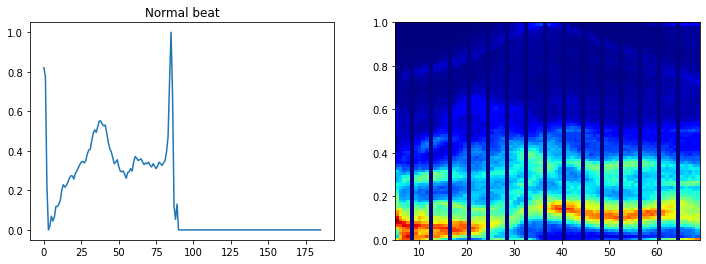

900000
900000


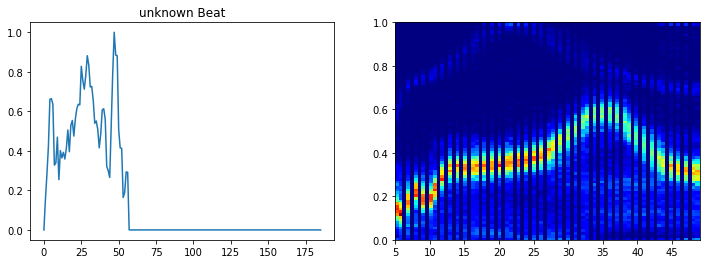

600000
600000


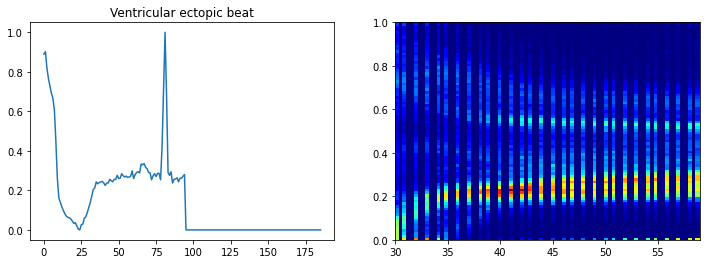

700000
700000


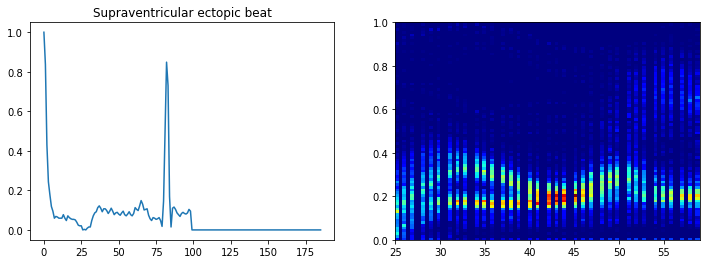

640000
640000


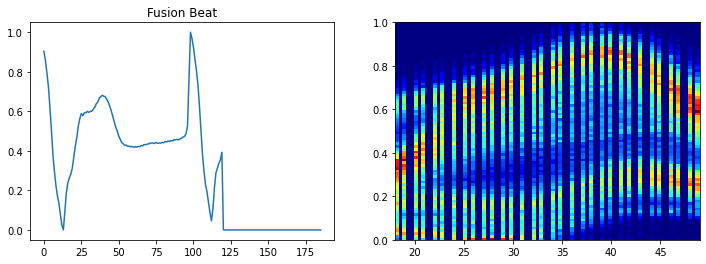

In [23]:
#################### Echantillonnage aléatoire des données par classe ####################
classes=train_df.groupby(187,group_keys=False).apply(lambda train_df : train_df.sample(1))
classes
##########################################################################################

#################### Normal Beat ####################

plt.figure(figsize=(12,4))
plt.subplot(1, 2, 1)  
plt.plot(classes.iloc[0,:186])
plt.title('Normal beat')
plt.subplot(1, 2, 2)  
plot_hist(0,70,5)
#####################################################

#################### unknown ####################
plt.figure(figsize=(12,4))
plt.subplot(1, 2, 1)
plt.plot(classes.iloc[1,:186])
plt.title('unknown Beat')
plt.subplot(1, 2, 2)  
plot_hist(1,50,5)
##################################################

#################### veb ####################
plt.figure(figsize=(12,4))
plt.subplot(1, 2, 1)  
plt.plot(classes.iloc[2,:186])
plt.title('Ventricular ectopic beat')
plt.subplot(1, 2, 2) 
plot_hist(2,60,30)
##############################################

#################### seb ####################
plt.figure(figsize=(12,4))
plt.subplot(1, 2, 1) 
plt.plot(classes.iloc[3,:186])
plt.title('Supraventricular ectopic beat')
plt.subplot(1, 2, 2) 
plot_hist(3,60,25)
#############################################

#################### fusion ####################
plt.figure(figsize=(12,4))
plt.subplot(1, 2, 1)   
plt.plot(classes.iloc[4,:186])
plt.title('Fusion Beat')
plt.subplot(1, 2, 2) 
plot_hist(4,50,18)
################################################


### Pré-traitement

In [24]:
################ Pré-traitement des données de sortie ################
target_train=train_df[187]
target_test=test_df[187]
y_train=to_categorical(target_train)
y_test=to_categorical(target_test)
X_train=train_df.iloc[:,:186].values
X_test=test_df.iloc[:,:186].values
for i in range(len(X_train)):
    X_train[i,:186]= add_gaussian_noise(X_train[i,:186])
X_train = X_train.reshape(len(X_train), X_train.shape[1],1)
X_test = X_test.reshape(len(X_test), X_test.shape[1],1)
#######################################################################

### Entrainement du modèle

In [25]:
model,history=network(X_train,y_train,X_test,y_test)

Epoch 1/20
3125/3125 [==============================] - 105s 33ms/step - loss: 0.3604 - accuracy: 0.8699 - val_loss: 0.3152 - val_accuracy: 0.8771
Epoch 2/20
3125/3125 [==============================] - 102s 33ms/step - loss: 0.1321 - accuracy: 0.9519 - val_loss: 0.2196 - val_accuracy: 0.9259
Epoch 3/20
3125/3125 [==============================] - 105s 33ms/step - loss: 0.0927 - accuracy: 0.9666 - val_loss: 0.1622 - val_accuracy: 0.9451
Epoch 4/20
3125/3125 [==============================] - 102s 33ms/step - loss: 0.0739 - accuracy: 0.9739 - val_loss: 0.1635 - val_accuracy: 0.9459
Epoch 5/20
3125/3125 [==============================] - 100s 32ms/step - loss: 0.0610 - accuracy: 0.9786 - val_loss: 0.2051 - val_accuracy: 0.9412
Epoch 6/20
3125/3125 [==============================] - 100s 32ms/step - loss: 0.0558 - accuracy: 0.9804 - val_loss: 0.1513 - val_accuracy: 0.9607
Epoch 7/20
3125/3125 [==============================] - 100s 32ms/step - loss: 0.0456 - accuracy: 0.9837 - val_loss: 0

### Evaluation du modèle

Précision: 96.07%


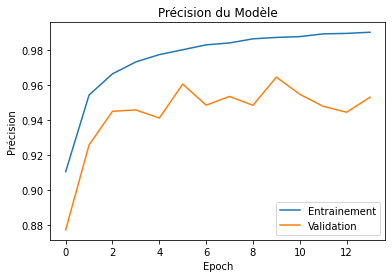

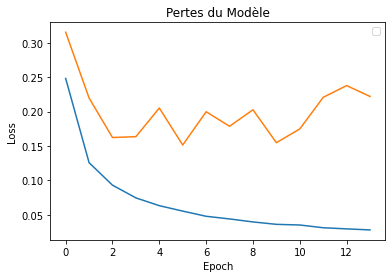

In [26]:
evaluate_model(history,X_test,y_test,model)
y_pred=model.predict(X_test)

### Matrice de confusion

Matrice de Confusion Normalisée


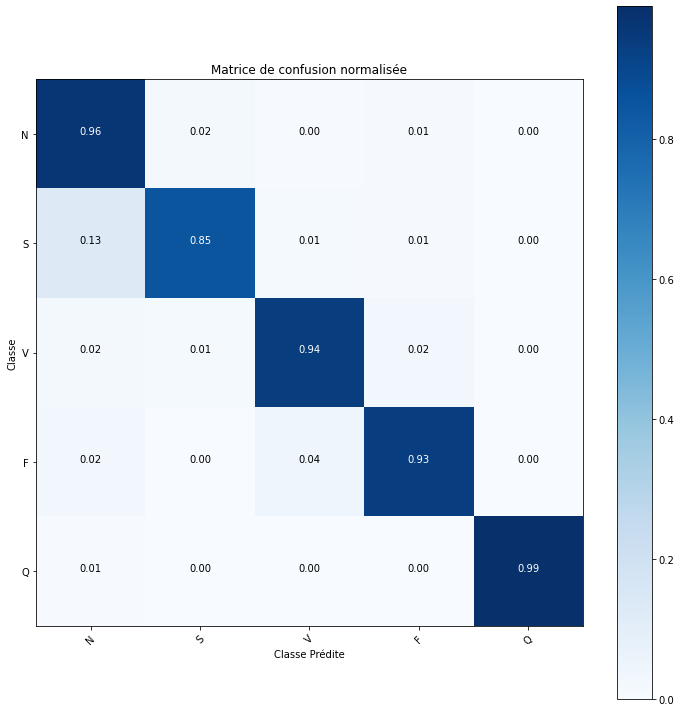

In [27]:
cnf_matrix = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
np.set_printoptions(precision=2)

plt.figure(figsize=(10, 10))
plot_confusion_matrix(cnf_matrix, classes=['N', 'S', 'V', 'F', 'Q'],normalize=True,
                      title='Matrice de confusion normalisée')
plt.show()

In [30]:
print(y_pred)

[[1.00e+00 2.43e-04 1.94e-06 2.66e-12 5.84e-10]
 [9.99e-01 3.00e-04 5.44e-04 2.83e-06 2.26e-04]
 [9.98e-01 2.41e-03 5.85e-09 1.01e-11 3.08e-06]
 ...
 [3.27e-08 3.32e-12 2.68e-11 2.47e-11 1.00e+00]
 [7.40e-12 2.52e-19 1.04e-13 2.27e-22 1.00e+00]
 [1.78e-11 2.16e-15 8.55e-12 2.73e-14 1.00e+00]]
